In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow import string as tf_string
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.layers import Embedding, Flatten

from sklearn.model_selection import train_test_split #
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score
from sklearn.preprocessing import normalize, OneHotEncoder
import scipy
import itertools
from sklearn.feature_extraction.text import CountVectorizer
import unicodedata, re, string
import nltk
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import LancasterStemmer


## Nacitanie

In [ ]:
dataset = pd.read_csv('../Data/final_dataset_2_balanced.csv')

## Rozdelenie dat na sady

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset['processed_text'], dataset['author_id'], test_size=0.20, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [ ]:
print(X_train[:10])

987     alert eyes like animal rebellious black hair c...
493     master-carpenter raised protesting hand mistak...
102     sharp exclamation captain brisket reply turned...
602     building snow house started pile snow packed h...
691     condition lost sad one circumstances lost fore...
947     breakfast elms improvement weather maximilian ...
201     since injured foot would course keep home go s...
281     almost simultaneously four heavy cudgels aligh...
1061    moment never really loved admired flirted wome...
1074    blue moon think one to-night little treat terr...
Name: processed_text, dtype: object


## One hot encoding

In [ ]:
one_hot_encoder = OneHotEncoder()

y_train = one_hot_encoder.fit_transform(y_train.to_numpy().reshape(-1, 1)).toarray()
y_valid = one_hot_encoder.transform(y_valid.to_numpy().reshape(-1, 1)).toarray()
y_test = one_hot_encoder.transform(y_test.to_numpy().reshape(-1, 1)).toarray()

In [ ]:
print(y_valid)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# CountVectorizer

In [ ]:
vectorizer = CountVectorizer()
X_train_cv = vectorizer.fit_transform(X_train).toarray()
X_test_cv = vectorizer.transform(X_test).toarray()
X_valid_cv = vectorizer.transform(X_valid).toarray()


In [ ]:
y_train.shape

(862, 20)

## Model 1

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(X_train_cv.shape[1],)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
])

model.summary()

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 512)               40214016  
                                                                 
 dropout_22 (Dropout)        (None, 512)               0         
                                                                 
 dense_31 (Dense)            (None, 256)               131328    
                                                                 
 dropout_23 (Dropout)        (None, 256)               0         
                                                                 
 dense_32 (Dense)            (None, 128)               32896     
                                                                 
 dropout_24 (Dropout)        (None, 128)               0         
                                                                 
 dense_33 (Dense)            (None, 64)               

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
# Train the model
history = model.fit(X_train_cv, y_train, validation_data=(X_valid_cv, y_valid), epochs=10, batch_size = 8, callbacks=[model_checkpoint_callback])

Epoch 1/10
108/108 [==============================] - 4s 28ms/step - loss: 2.7028 - accuracy: 0.2749 - val_loss: 1.3363 - val_accuracy: 0.6875
Epoch 2/10
108/108 [==============================] - 3s 25ms/step - loss: 1.1513 - accuracy: 0.6903 - val_loss: 0.7549 - val_accuracy: 0.8438
Epoch 3/10
108/108 [==============================] - 3s 31ms/step - loss: 0.5937 - accuracy: 0.8759 - val_loss: 0.5448 - val_accuracy: 0.9271
Epoch 4/10
108/108 [==============================] - 3s 26ms/step - loss: 0.2720 - accuracy: 0.9292 - val_loss: 0.4615 - val_accuracy: 0.9479
Epoch 5/10
108/108 [==============================] - 2s 15ms/step - loss: 0.1352 - accuracy: 0.9814 - val_loss: 0.5225 - val_accuracy: 0.9479
Epoch 6/10
108/108 [==============================] - 3s 27ms/step - loss: 0.0878 - accuracy: 0.9884 - val_loss: 0.3869 - val_accuracy: 0.9375
Epoch 7/10
108/108 [==============================] - 2s 15ms/step - loss: 0.0643 - accuracy: 0.9919 - val_loss: 0.4171 - val_accuracy: 0.9479

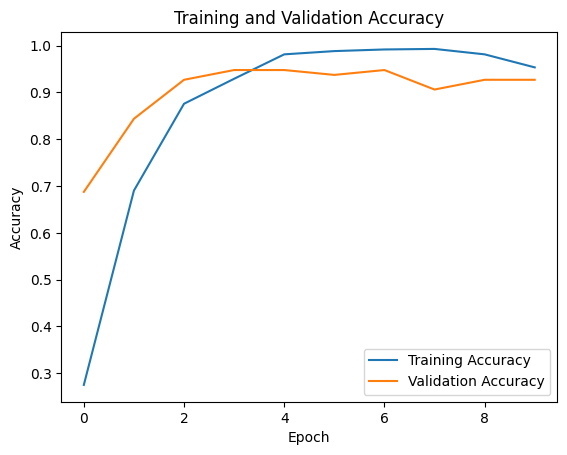

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test_cv, y_test, verbose=0)

y_pred_probs = model.predict(X_test_cv)
y_pred = np.argmax(y_pred_probs, axis=1)
y_test_indices = np.argmax(y_test, axis=1)

test_f1 = f1_score(y_test_indices, y_pred, average='macro')
test_precision = precision_score(y_test_indices, y_pred, average='macro')
test_recall = recall_score(y_test_indices, y_pred, average='macro')

print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')
print(f'Test F1 Score: {test_f1}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}')

8/8 [==============================] - 0s 8ms/step
Test loss: 0.25491419434547424
Test accuracy: 0.949999988079071
Test F1 Score: 0.9443306442669701
Test Precision: 0.9526634272590156
Test Recall: 0.9437176712176714


# TextVectorization

## Model 2


In [ ]:
embedding_dim = 256
vocab_size = 60000
sequence_length = 6000

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(dataset['processed_text'].values)

In [ ]:
model = tf.keras.Sequential([
    vect_layer,
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=sequence_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
])

model.summary()

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_3 (Text  (None, 6000)              0         
 Vectorization)                                                  
                                                                 
 embedding_3 (Embedding)     (None, 6000, 256)         15360000  
                                                                 
 global_average_pooling1d_3  (None, 256)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_24 (Dense)            (None, 128)               32896     
                                                                 
 dropout_18 (Dropout)        (None, 128)               0         
                                                                 
 dense_25 (Dense)            (None, 64)               

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=15, batch_size = 8, callbacks=[model_checkpoint_callback])

Epoch 1/15
108/108 [==============================] - 14s 119ms/step - loss: 2.8793 - accuracy: 0.0951 - val_loss: 2.7427 - val_accuracy: 0.0833
Epoch 2/15
108/108 [==============================] - 12s 110ms/step - loss: 2.5813 - accuracy: 0.1520 - val_loss: 2.3885 - val_accuracy: 0.3021
Epoch 3/15
108/108 [==============================] - 12s 107ms/step - loss: 2.1123 - accuracy: 0.3295 - val_loss: 1.9615 - val_accuracy: 0.3021
Epoch 4/15
108/108 [==============================] - 11s 105ms/step - loss: 1.5835 - accuracy: 0.4733 - val_loss: 1.4182 - val_accuracy: 0.5833
Epoch 5/15
108/108 [==============================] - 11s 103ms/step - loss: 1.1159 - accuracy: 0.6450 - val_loss: 1.0763 - val_accuracy: 0.6250
Epoch 6/15
108/108 [==============================] - 11s 102ms/step - loss: 0.8225 - accuracy: 0.7587 - val_loss: 0.7169 - val_accuracy: 0.8438
Epoch 7/15
108/108 [==============================] - 11s 98ms/step - loss: 0.5322 - accuracy: 0.8654 - val_loss: 0.5644 - val_acc

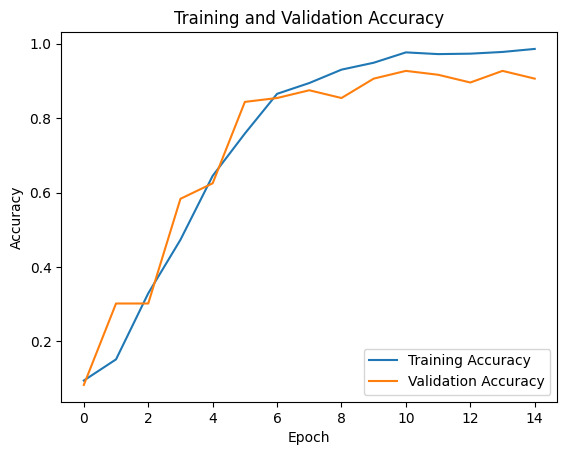

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

8/8 [==============================] - 0s 30ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted')
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.9333333333333333
F1 Score: 0.9344676970199136
Precision: 0.9448955939213293
Recall: 0.9333333333333333


## Model 2 - vacsi vocab_site


In [ ]:
embedding_dim = 512
vocab_size = 90000
sequence_length = 9000

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(dataset['processed_text'].values)

In [ ]:
model = tf.keras.Sequential([
    vect_layer,
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=sequence_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
])

model.summary()

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 9000)              0         
 Vectorization)                                                  
                                                                 
 embedding_2 (Embedding)     (None, 9000, 512)         46080000  
                                                                 
 global_average_pooling1d_2  (None, 512)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_6 (Dense)             (None, 512)               262656    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 256)              

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=15, batch_size = 8, callbacks=[model_checkpoint_callback])

Epoch 1/15
108/108 [==============================] - 16s 134ms/step - loss: 2.8009 - accuracy: 0.1044 - val_loss: 2.6805 - val_accuracy: 0.1458
Epoch 2/15
108/108 [==============================] - 13s 124ms/step - loss: 2.3932 - accuracy: 0.2030 - val_loss: 2.2039 - val_accuracy: 0.2396
Epoch 3/15
108/108 [==============================] - 14s 127ms/step - loss: 1.7392 - accuracy: 0.3852 - val_loss: 1.5805 - val_accuracy: 0.4271
Epoch 4/15
108/108 [==============================] - 13s 124ms/step - loss: 1.0537 - accuracy: 0.6311 - val_loss: 1.1244 - val_accuracy: 0.5938
Epoch 5/15
108/108 [==============================] - 13s 119ms/step - loss: 0.5777 - accuracy: 0.8341 - val_loss: 0.7188 - val_accuracy: 0.7917
Epoch 6/15
108/108 [==============================] - 14s 125ms/step - loss: 0.3261 - accuracy: 0.9084 - val_loss: 0.6220 - val_accuracy: 0.7604
Epoch 7/15
108/108 [==============================] - 12s 115ms/step - loss: 0.1841 - accuracy: 0.9548 - val_loss: 0.4206 - val_ac

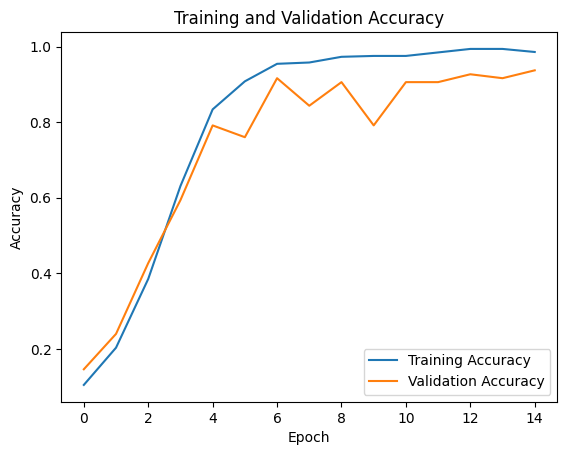

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

8/8 [==============================] - 0s 36ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted')
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.9375
F1 Score: 0.9369172024100823
Precision: 0.9472529611592112
Recall: 0.9375
